In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from matplotlib import pyplot as plt
import time

In [2]:
# Choose which device to use
use_cuda = True

if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

## Load the dataset

In [3]:
import torchvision.datasets
import torchvision.transforms as transforms

# Apply transformations to the data points before passing them to the network
transform = transforms.Compose([transforms.ToTensor(),  # Transform the data to torch tensors of shape (28, 28, 1), corresponding to 28 * 28 pixels with 1 channel (1 value per pixel that is)
                                transforms.Lambda(lambda x: x.squeeze()),  # Squeeze the data to remove the redundant channel dimension (to obtain tensors of shape (28, 28))
                                ])

# Download the MNIST train dataset (used to train the network)
trainset = torchvision.datasets.MNIST(root='./data_mnist',
                                      train=True,
                                      download=True,
                                      transform=transform  # Apply the defined transformation on the data
                                      )

# Download the MNIST test dataset (used to evaluate the trained network)
testset = torchvision.datasets.MNIST(root='./data_mnist',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )

In [54]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,  # Shuffle the dataset for random ordering of train samples
                                          drop_last=True
                                          )

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True
                                         )

## Defined necessarily code for the Network and Training

In [5]:
class MLP(nn.Module):

    def __init__(self,
               input_size,  # Size of the input. Here we will first flatten the image to a single vector with the 3 * 32 * 32 values in the image 
               layer_sizes,  # A tuple containing the sizes of the hidden layers of the neural network. So to create a NN with two hidden layers with 32 neurons in each layer you'd set layer_sizes=(32,32)
               output_size):  # The size of the network output. CIFAR10 has 10 output classes
        super(MLP, self).__init__()
        shape = (input_size,) + tuple(layer_sizes) + (output_size,)
        self.layers = nn.ModuleList([nn.Linear(shape[i], shape[i + 1]) for i in range(len(shape) - 1)])  # Store the layers in a ModuleList object so they are recognized by pytorch as submodules of this model

    def forward(self, x):
        for layer in self.layers[:-1]:  # Apply relu activation to all but the last layer in the network
            x = F.relu(layer(x))
        return self.layers[-1](x)

In [13]:
def train(model, criterion, optimizer, trainloader, testloader, epochs):
    print(model)
    print(optimizer)
    
    test_acc  = []
    train_acc = []
    start = time.time()

    for epoch in range(1, epochs+1):
        
        total_correct, total_cnt = 0, 0
    
        for i, (minibatch_data, minibatch_label) in enumerate(trainloader):
            minibatch_data, minibatch_label = minibatch_data.to(device), minibatch_label.to(device)

            # Set dL/dU, dL/dV, dL/dW to be filled with zeros
            optimizer.zero_grad()
      
            #reshape the minibatch
            inputs = minibatch_data.view(-1, 784)

            # forward the minibatch through the net  
            prob = model(inputs) 
      
            # Compute the average of the losses of the data points in the minibatch
            loss = criterion(prob, minibatch_label) 
      
            # backward pass to compute dL/dU, dL/dV and dL/dW    
            loss.backward()
      
            # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
            optimizer.step()
        
            # Compute relevant metrics
            prod_max = torch.argmax(prob, dim=1)  # Get the labels with highest output probability

            correct = torch.sum(torch.eq(prod_max, minibatch_label)).item()  # Count how many are equal to the true labels
            total_correct += correct
            
            total_cnt += minibatch_data.shape[0]
        
            # Show progress every 20 batches 
            #if not i % 20:
            #    print(f'epoch: {epoch}, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')
    
        elapsed = time.time() - start
        train_acc.append(total_correct / len(trainset.data))
        print(f'Epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {train_acc[-1]:.3f}')
    
        # Evaluate the model on the test set
        total_correct = 0
        for i, (x_batch, y_batch) in enumerate(testloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

            prob = model(x_batch.view(-1, 784))
            prob_max = torch.argmax(prob, dim=1)

            total_correct += torch.sum(torch.eq(prob_max, y_batch)).item()

        test_acc.append(total_correct / len(testset.data))
        print(f'Test accuracy: {test_acc[-1]:.3f}')

    return train_acc, test_acc


## Understand which SGD learning rate to use

In [7]:
all_sgd_train_acc = []
all_sgd_test_acc = []

lrs = [1., 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
epochs = 25

for lr in lrs:
    print('Learning rate:', lr)
    model = MLP(784, (50, 50), 10).to(device)  # Create a new dense neural network with two hidden layers of size 50

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer=torch.optim.SGD(model.parameters() , lr=lr)

    sgd_train_acc, sgd_test_acc = train(model, criterion, optimizer, trainloader, testloader, epochs)
    
    all_sgd_train_acc.append(sgd_train_acc)
    all_sgd_test_acc.append(sgd_test_acc)


Learning rate: 1.0
Epoch: 1, time: 6.407s, loss: 0.408, train accuracy: 0.698
Test accuracy: 0.904
Epoch: 2, time: 13.358s, loss: 0.181, train accuracy: 0.912
Test accuracy: 0.925
Epoch: 3, time: 20.378s, loss: 0.261, train accuracy: 0.929
Test accuracy: 0.939
Epoch: 4, time: 27.415s, loss: 0.227, train accuracy: 0.939
Test accuracy: 0.936
Epoch: 5, time: 34.487s, loss: 0.089, train accuracy: 0.946
Test accuracy: 0.944
Epoch: 6, time: 41.447s, loss: 0.111, train accuracy: 0.949
Test accuracy: 0.948
Epoch: 7, time: 48.391s, loss: 0.218, train accuracy: 0.955
Test accuracy: 0.933
Epoch: 8, time: 55.369s, loss: 0.127, train accuracy: 0.957
Test accuracy: 0.953
Epoch: 9, time: 62.707s, loss: 0.139, train accuracy: 0.958
Test accuracy: 0.954
Epoch: 10, time: 69.671s, loss: 0.135, train accuracy: 0.961
Test accuracy: 0.958
Epoch: 11, time: 76.503s, loss: 0.107, train accuracy: 0.963
Test accuracy: 0.953
Epoch: 12, time: 83.340s, loss: 0.226, train accuracy: 0.964
Test accuracy: 0.945
Epoch: 

Epoch: 25, time: 197.474s, loss: 0.044, train accuracy: 0.980
Test accuracy: 0.969
Learning rate: 0.01
Epoch: 1, time: 6.577s, loss: 1.900, train accuracy: 0.411
Test accuracy: 0.657
Epoch: 2, time: 14.614s, loss: 0.771, train accuracy: 0.749
Test accuracy: 0.832
Epoch: 3, time: 22.718s, loss: 0.534, train accuracy: 0.845
Test accuracy: 0.868
Epoch: 4, time: 31.818s, loss: 0.345, train accuracy: 0.871
Test accuracy: 0.884
Epoch: 5, time: 41.158s, loss: 0.340, train accuracy: 0.886
Test accuracy: 0.893
Epoch: 6, time: 50.095s, loss: 0.479, train accuracy: 0.894
Test accuracy: 0.901
Epoch: 7, time: 58.998s, loss: 0.266, train accuracy: 0.899
Test accuracy: 0.904
Epoch: 8, time: 67.787s, loss: 0.440, train accuracy: 0.904
Test accuracy: 0.911
Epoch: 9, time: 76.295s, loss: 0.325, train accuracy: 0.907
Test accuracy: 0.913
Epoch: 10, time: 84.584s, loss: 0.339, train accuracy: 0.910
Test accuracy: 0.915
Epoch: 11, time: 92.565s, loss: 0.260, train accuracy: 0.914
Test accuracy: 0.918
Epoch

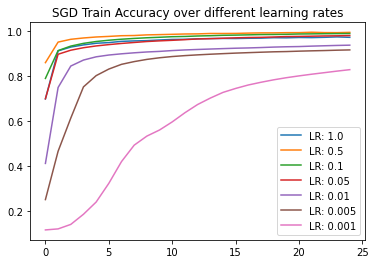

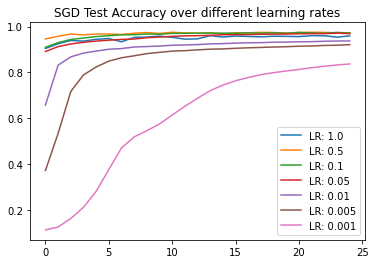

In [8]:
plt.figure()
for i, lr in enumerate(lrs):
    plt.plot(range(len(all_sgd_train_acc[i])), all_sgd_train_acc[i], label=f'LR: {lr}')
    plt.title('SGD Train Accuracy over different learning rates')
    plt.legend()
    
plt.figure()
for i, lr in enumerate(lrs):
    plt.plot(range(len(all_sgd_test_acc[i])), all_sgd_test_acc[i], label=f'LR: {lr}')
    plt.title('SGD Test Accuracy over different learning rates')
    plt.legend()

# Question 2a

## SGD

Learning the SGD solution 5 times to compare results

In [9]:
# understand different initialisations for SGD - repeats N times with random initialisation
all_sgd_repeat_train_acc = []
all_sgd_repeat_test_acc = []

lr = 0.5
epochs = 25
repeats = 5

for i in range(repeats):
    print('Iteration:', i)
    model = MLP(784, (50, 50), 10).to(device)  # Create a new dense neural network with two hidden layers of size 128

    criterion = nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(model.parameters() , lr=lr)

    sgd_train_acc, sgd_test_acc = train(model, criterion, optimizer, trainloader, testloader, epochs)
    
    all_sgd_repeat_train_acc.append(sgd_train_acc)
    all_sgd_repeat_test_acc.append(sgd_test_acc)


Iteration: 0
Epoch: 1, time: 6.221s, loss: 0.105, train accuracy: 0.855
Test accuracy: 0.944
Epoch: 2, time: 13.240s, loss: 0.036, train accuracy: 0.950
Test accuracy: 0.953
Epoch: 3, time: 20.137s, loss: 0.206, train accuracy: 0.962
Test accuracy: 0.959
Epoch: 4, time: 27.085s, loss: 0.083, train accuracy: 0.968
Test accuracy: 0.970
Epoch: 5, time: 34.010s, loss: 0.169, train accuracy: 0.973
Test accuracy: 0.965
Epoch: 6, time: 40.930s, loss: 0.122, train accuracy: 0.974
Test accuracy: 0.966
Epoch: 7, time: 48.193s, loss: 0.140, train accuracy: 0.977
Test accuracy: 0.971
Epoch: 8, time: 55.133s, loss: 0.135, train accuracy: 0.980
Test accuracy: 0.959
Epoch: 9, time: 62.026s, loss: 0.014, train accuracy: 0.982
Test accuracy: 0.972
Epoch: 10, time: 69.088s, loss: 0.073, train accuracy: 0.983
Test accuracy: 0.971
Epoch: 11, time: 75.992s, loss: 0.059, train accuracy: 0.984
Test accuracy: 0.972
Epoch: 12, time: 82.973s, loss: 0.077, train accuracy: 0.985
Test accuracy: 0.972
Epoch: 13, ti

Test accuracy: 0.973
Iteration: 4
Epoch: 1, time: 8.141s, loss: 0.365, train accuracy: 0.865
Test accuracy: 0.937
Epoch: 2, time: 17.501s, loss: 0.170, train accuracy: 0.953
Test accuracy: 0.955
Epoch: 3, time: 26.504s, loss: 0.138, train accuracy: 0.965
Test accuracy: 0.964
Epoch: 4, time: 35.137s, loss: 0.087, train accuracy: 0.971
Test accuracy: 0.967
Epoch: 5, time: 43.434s, loss: 0.026, train accuracy: 0.975
Test accuracy: 0.969
Epoch: 6, time: 51.180s, loss: 0.092, train accuracy: 0.978
Test accuracy: 0.971
Epoch: 7, time: 58.723s, loss: 0.088, train accuracy: 0.980
Test accuracy: 0.971
Epoch: 8, time: 66.134s, loss: 0.021, train accuracy: 0.982
Test accuracy: 0.970
Epoch: 9, time: 73.492s, loss: 0.063, train accuracy: 0.984
Test accuracy: 0.972
Epoch: 10, time: 80.855s, loss: 0.084, train accuracy: 0.986
Test accuracy: 0.968
Epoch: 11, time: 87.971s, loss: 0.015, train accuracy: 0.987
Test accuracy: 0.973
Epoch: 12, time: 95.097s, loss: 0.064, train accuracy: 0.987
Test accuracy

Train min: 0.9921 max: 0.9956166666666667
Train results [0.9937, 0.9930833333333333, 0.9950333333333333, 0.9921, 0.9956166666666667]


Test min: 0.9676 max: 0.9745
Test result [0.9729, 0.9676, 0.9745, 0.9728, 0.9732]


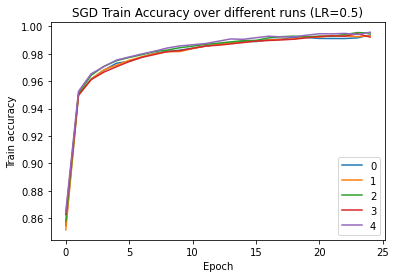

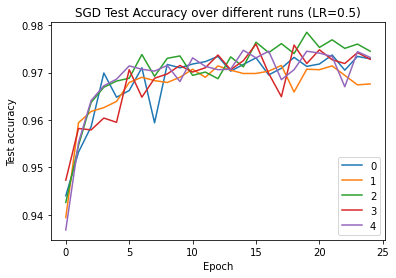

In [58]:
plt.figure()
for i in range(repeats):
    plt.plot(range(len(all_sgd_repeat_train_acc[i])), all_sgd_repeat_train_acc[i], label=i)
    plt.title(f'SGD Train Accuracy over different runs (LR={lr})')
    plt.ylabel('Train accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
plt.figure()
for i in range(repeats):
    plt.plot(range(len(all_sgd_repeat_test_acc[i])), all_sgd_repeat_test_acc[i], label=i)
    plt.title(f'SGD Test Accuracy over different runs (LR={lr})')
    plt.ylabel('Test accuracy')
    plt.xlabel('Epoch')
    plt.legend()

# some stats
last_train = [t[-1] for t in all_sgd_repeat_train_acc] 
print('Train min:', min(last_train), 'max:', max(last_train))
print('Train results', last_train)
print('\n')
last_test = [t[-1] for t in all_sgd_repeat_test_acc]
print('Test min:', min(last_test), 'max:', max(last_test))
print('Test result', last_test)

## ADAM
Learning the ADAM solution 5 times to compare results

In [14]:
# understand different initialisations for SGD - repeats N times with random initialisation
all_adam_train_acc = []
all_adam_test_acc = []

adam_lr = 0.001
epochs = 25
repeats = 5

for i in range(repeats):
    print('Iteration:', i)
    model = MLP(784, (50, 50), 10).to(device)  # Create a new dense neural network with two hidden layers of size 50

    criterion = nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters() , lr=adam_lr)

    adam_train_acc, adam_test_acc = train(model, criterion, optimizer, trainloader, testloader, epochs)
    
    all_adam_train_acc.append(adam_train_acc)
    all_adam_test_acc.append(adam_test_acc)


Iteration: 0
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch: 1, time: 6.775s, loss: 0.286, train accuracy: 0.860
Test accuracy: 0.923
Epoch: 2, time: 14.306s, loss: 0.241, train accuracy: 0.930
Test accuracy: 0.941
Epoch: 3, time: 21.845s, loss: 0.110, train accuracy: 0.946
Test accuracy: 0.952
Epoch: 4, time: 29.576s, loss: 0.099, train accuracy: 0.956
Test accuracy: 0.957
Epoch: 5, time: 37.761s, loss: 0.174, train accuracy: 0.962
Test accuracy: 0.960
Epoch: 6, time: 45.622s, loss: 0.085, train accuracy: 0.968
Test accuracy: 0.967
Epoch: 7, time: 53.180s, loss: 0.047, train accuracy: 0.971
Test accuracy: 0.966
Epoch: 8, time: 60.871s, loss: 0.029, train accuracy: 0.974
Test accuracy: 0.969
Epoch

Epoch: 9, time: 71.083s, loss: 0.055, train accuracy: 0.978
Test accuracy: 0.969
Epoch: 10, time: 79.699s, loss: 0.024, train accuracy: 0.980
Test accuracy: 0.967
Epoch: 11, time: 88.513s, loss: 0.032, train accuracy: 0.983
Test accuracy: 0.971
Epoch: 12, time: 97.615s, loss: 0.080, train accuracy: 0.983
Test accuracy: 0.971
Epoch: 13, time: 106.809s, loss: 0.043, train accuracy: 0.985
Test accuracy: 0.969
Epoch: 14, time: 115.811s, loss: 0.024, train accuracy: 0.985
Test accuracy: 0.971
Epoch: 15, time: 124.294s, loss: 0.017, train accuracy: 0.987
Test accuracy: 0.971
Epoch: 16, time: 132.895s, loss: 0.029, train accuracy: 0.988
Test accuracy: 0.970
Epoch: 17, time: 141.440s, loss: 0.023, train accuracy: 0.989
Test accuracy: 0.971
Epoch: 18, time: 149.423s, loss: 0.051, train accuracy: 0.990
Test accuracy: 0.970
Epoch: 19, time: 157.427s, loss: 0.012, train accuracy: 0.990
Test accuracy: 0.972
Epoch: 20, time: 165.236s, loss: 0.025, train accuracy: 0.992
Test accuracy: 0.969
Epoch: 21

Train min/max 0.9932 0.9940333333333333
Train results [0.9932, 0.99355, 0.9940333333333333, 0.99365, 0.9934833333333334]


Test min/max 0.9668 0.973
Test results [0.9685, 0.973, 0.9712, 0.9668, 0.9693]


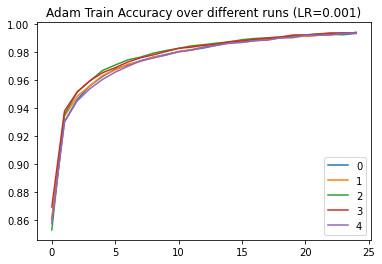

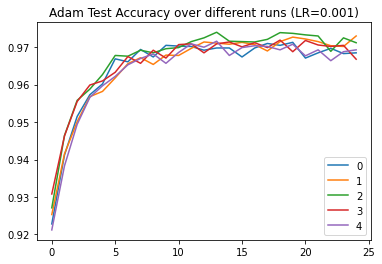

In [60]:
plt.figure()
for i in range(repeats):
    plt.plot(range(len(all_adam_train_acc[i])), all_adam_train_acc[i], label=i)
    plt.title(f'Adam Train Accuracy over different runs (LR={adam_lr})')
    plt.legend()
    
plt.figure()
for i in range(repeats):
    plt.plot(range(len(all_adam_test_acc[i])), all_adam_test_acc[i], label=i)
    plt.title(f'Adam Test Accuracy over different runs (LR={adam_lr})')
    plt.legend()

last_train = [t[-1] for t in all_adam_train_acc] 
print('Train min/max', min(last_train), max(last_train))
print('Train results', last_train)
print('\n')
last_test = [t[-1] for t in all_adam_test_acc]
print('Test min/max', min(last_test), max(last_test))
print('Test results', last_test)


## Comparing Adam and SGD using first runs

ADAM Training max accuracy during run: [0.9932, 0.9934833333333334, 0.99355, 0.9936833333333334, 0.9940333333333333]
ADAM mean: 0.99359
SGD Train max accuracy during run [0.9931, 0.9937, 0.9945, 0.9953833333333333, 0.9956166666666667]
SGD mean: 0.9944599999999999


ADAM Test max accuracy during run [0.9713, 0.9716, 0.9719, 0.973, 0.974]
ADAM mean: 0.9723599999999999
SGD Test max accuracy during run [0.9715, 0.9737, 0.9747, 0.976, 0.9785]
SGD mean: 0.9748800000000001


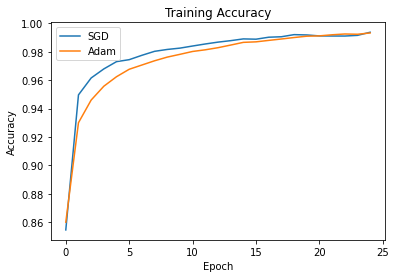

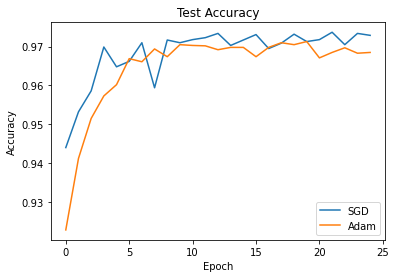

In [69]:
plt.figure()
plt.plot(range(len(all_sgd_repeat_train_acc[0])), all_sgd_repeat_train_acc[0], label='SGD')
plt.plot(range(len(all_adam_train_acc[0])), all_adam_train_acc[0], label='Adam')
plt.title(f'Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
    
plt.figure()
plt.plot(range(len(all_sgd_repeat_test_acc[0])), all_sgd_repeat_test_acc[0], label='SGD')
plt.plot(range(len(all_adam_test_acc[0])), all_adam_test_acc[0], label='Adam')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# some stats
max_train = [max(t) for t in all_adam_train_acc] 
max_train.sort()
print('ADAM Training max accuracy during run:', max_train)
print('ADAM mean:', sum(max_train)/len(max_train))
max_train = [max(t) for t in all_sgd_repeat_train_acc] 
max_train.sort()
print('SGD Train max accuracy during run', max_train)
print('SGD mean:', sum(max_train)/len(max_train))
print('\n')
max_test = [max(t) for t in all_adam_test_acc]
max_test.sort()
print('ADAM Test max accuracy during run', max_test)
print('ADAM mean:', sum(max_test)/len(max_test))
max_test = [max(t) for t in all_sgd_repeat_test_acc]
max_test.sort()
print('SGD Test max accuracy during run', max_test)
print('SGD mean:', sum(max_test)/len(max_test))

In [72]:
# dump test values for each run
print('ADAM')
print('-'*10)
for i in range(5):
    max_test = max(all_adam_test_acc[i])
    print('max of', max_test, 'at epoch', all_adam_test_acc[i].index(max_test)+1)

print('\n')
print('SGD')
print('-'*10)    
for i in range(5):
    max_test = max(all_sgd_repeat_test_acc[i])
    print('max of', max_test, 'at epoch', all_sgd_repeat_test_acc[i].index(max_test)+1)
    

ADAM
----------
max of 0.9713 at epoch 20
max of 0.973 at epoch 25
max of 0.974 at epoch 14
max of 0.9719 at epoch 19
max of 0.9716 at epoch 14


SGD
----------
max of 0.9737 at epoch 22
max of 0.9715 at epoch 18
max of 0.9785 at epoch 20
max of 0.976 at epoch 16
max of 0.9747 at epoch 15


# Question 2b

## Comparison of training with varying depth of network

In [27]:
def train_to_depth(depth, optimizer_class, lr, trainloader, testloader, epochs):
    all_depth_train_acc = []
    all_depth_test_acc = []

    for d in range(depth):
        print('Depth:', d+1)
        hidden_layer = tuple([50]*(d+1))
        model = MLP(784, hidden_layer, 10).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer_class(model.parameters() , lr=lr)

        train_acc, test_acc = train(model, criterion, optimizer, trainloader, testloader, epochs)
    
        all_depth_train_acc.append(train_acc)
        all_depth_test_acc.append(test_acc)
        
    return all_depth_train_acc, all_depth_test_acc


Train SGD with learning rate 0.5 from 1 to 20 hidden layers with 50 hidden nodes in each layer.

In [28]:
sgd_lr = 0.5
epochs = 25
depth = 20

sgd_train_depth_acc, sgd_test_depth_acc = train_to_depth(depth, torch.optim.SGD, sgd_lr, trainloader, testloader, epochs)


Depth: 1
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.5
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 1, time: 5.708s, loss: 0.122, train accuracy: 0.894
Test accuracy: 0.949
Epoch: 2, time: 12.040s, loss: 0.153, train accuracy: 0.954
Test accuracy: 0.955
Epoch: 3, time: 18.342s, loss: 0.124, train accuracy: 0.964
Test accuracy: 0.964
Epoch: 4, time: 24.955s, loss: 0.089, train accuracy: 0.970
Test accuracy: 0.970
Epoch: 5, time: 31.722s, loss: 0.107, train accuracy: 0.974
Test accuracy: 0.969
Epoch: 6, time: 38.531s, loss: 0.041, train accuracy: 0.977
Test accuracy: 0.971
Epoch: 7, time: 44.935s, loss: 0.088, train accuracy: 0.979
Test accuracy: 0.972
Epoch: 8, time: 51.312s, loss: 0.061, train accuracy: 0.981
Test accuracy: 0.973
Epoch: 9, time: 57.623s, loss: 0.055, train accuracy: 0.982
Test accuracy: 0.

Test accuracy: 0.962
Epoch: 9, time: 70.457s, loss: 0.065, train accuracy: 0.979
Test accuracy: 0.966
Epoch: 10, time: 77.693s, loss: 0.007, train accuracy: 0.981
Test accuracy: 0.968
Epoch: 11, time: 84.860s, loss: 0.022, train accuracy: 0.982
Test accuracy: 0.969
Epoch: 12, time: 91.986s, loss: 0.014, train accuracy: 0.983
Test accuracy: 0.969
Epoch: 13, time: 99.147s, loss: 0.042, train accuracy: 0.984
Test accuracy: 0.969
Epoch: 14, time: 106.303s, loss: 0.030, train accuracy: 0.985
Test accuracy: 0.970
Epoch: 15, time: 113.434s, loss: 0.031, train accuracy: 0.986
Test accuracy: 0.973
Epoch: 16, time: 120.632s, loss: 0.061, train accuracy: 0.987
Test accuracy: 0.972
Epoch: 17, time: 127.736s, loss: 0.019, train accuracy: 0.988
Test accuracy: 0.972
Epoch: 18, time: 134.839s, loss: 0.008, train accuracy: 0.987
Test accuracy: 0.971
Epoch: 19, time: 141.924s, loss: 0.068, train accuracy: 0.989
Test accuracy: 0.962
Epoch: 20, time: 149.027s, loss: 0.021, train accuracy: 0.990
Test accur

Test accuracy: 0.963
Epoch: 13, time: 111.804s, loss: 0.043, train accuracy: 0.976
Test accuracy: 0.967
Epoch: 14, time: 120.132s, loss: 0.030, train accuracy: 0.978
Test accuracy: 0.963
Epoch: 15, time: 128.539s, loss: 0.094, train accuracy: 0.979
Test accuracy: 0.966
Epoch: 16, time: 136.958s, loss: 0.081, train accuracy: 0.980
Test accuracy: 0.965
Epoch: 17, time: 144.894s, loss: 0.019, train accuracy: 0.980
Test accuracy: 0.967
Epoch: 18, time: 152.863s, loss: 0.033, train accuracy: 0.980
Test accuracy: 0.968
Epoch: 19, time: 160.764s, loss: 0.072, train accuracy: 0.982
Test accuracy: 0.963
Epoch: 20, time: 168.986s, loss: 0.017, train accuracy: 0.983
Test accuracy: 0.966
Epoch: 21, time: 178.035s, loss: 0.067, train accuracy: 0.983
Test accuracy: 0.967
Epoch: 22, time: 186.598s, loss: 0.112, train accuracy: 0.983
Test accuracy: 0.966
Epoch: 23, time: 195.345s, loss: 0.066, train accuracy: 0.984
Test accuracy: 0.968
Epoch: 24, time: 204.515s, loss: 0.036, train accuracy: 0.986
Test

Test accuracy: 0.103
Epoch: 11, time: 99.994s, loss: 2.299, train accuracy: 0.110
Test accuracy: 0.114
Epoch: 12, time: 109.344s, loss: 2.300, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 13, time: 118.567s, loss: 2.304, train accuracy: 0.110
Test accuracy: 0.101
Epoch: 14, time: 127.900s, loss: 2.298, train accuracy: 0.109
Test accuracy: 0.113
Epoch: 15, time: 137.073s, loss: 2.298, train accuracy: 0.111
Test accuracy: 0.113
Epoch: 16, time: 146.017s, loss: 2.301, train accuracy: 0.111
Test accuracy: 0.113
Epoch: 17, time: 154.635s, loss: 2.303, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 18, time: 163.222s, loss: 2.308, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 19, time: 171.765s, loss: 2.291, train accuracy: 0.110
Test accuracy: 0.114
Epoch: 20, time: 180.354s, loss: 2.319, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 21, time: 188.908s, loss: 2.291, train accuracy: 0.111
Test accuracy: 0.113
Epoch: 22, time: 197.541s, loss: 2.306, train accuracy: 0.110
Test 

Epoch: 1, time: 8.328s, loss: 2.281, train accuracy: 0.109
Test accuracy: 0.103
Epoch: 2, time: 17.633s, loss: 2.299, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 3, time: 26.821s, loss: 2.313, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 4, time: 36.435s, loss: 2.295, train accuracy: 0.110
Test accuracy: 0.114
Epoch: 5, time: 45.723s, loss: 2.300, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 6, time: 55.054s, loss: 2.293, train accuracy: 0.111
Test accuracy: 0.113
Epoch: 7, time: 64.370s, loss: 2.294, train accuracy: 0.111
Test accuracy: 0.113
Epoch: 8, time: 73.599s, loss: 2.291, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 9, time: 82.830s, loss: 2.291, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 10, time: 92.069s, loss: 2.299, train accuracy: 0.111
Test accuracy: 0.101
Epoch: 11, time: 101.319s, loss: 2.305, train accuracy: 0.109
Test accuracy: 0.114
Epoch: 12, time: 110.548s, loss: 2.298, train accuracy: 0.110
Test accuracy: 0.103
Epoch: 13, time: 119.727

Test accuracy: 0.113
Epoch: 25, time: 253.483s, loss: 2.303, train accuracy: 0.110
Test accuracy: 0.101
Depth: 16
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): Linear(in_features=50, out_features=50, bias=True)
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): Linear(in_features=50, out_features=50, bias=True)
    (14): Li

Epoch: 4, time: 41.344s, loss: 2.297, train accuracy: 0.110
Test accuracy: 0.103
Epoch: 5, time: 51.886s, loss: 2.289, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 6, time: 62.472s, loss: 2.297, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 7, time: 72.996s, loss: 2.299, train accuracy: 0.111
Test accuracy: 0.113
Epoch: 8, time: 83.939s, loss: 2.298, train accuracy: 0.111
Test accuracy: 0.114
Epoch: 9, time: 94.452s, loss: 2.309, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 10, time: 104.942s, loss: 2.301, train accuracy: 0.111
Test accuracy: 0.113
Epoch: 11, time: 115.507s, loss: 2.300, train accuracy: 0.109
Test accuracy: 0.113
Epoch: 12, time: 126.006s, loss: 2.301, train accuracy: 0.109
Test accuracy: 0.113
Epoch: 13, time: 136.538s, loss: 2.304, train accuracy: 0.110
Test accuracy: 0.101
Epoch: 14, time: 146.993s, loss: 2.307, train accuracy: 0.110
Test accuracy: 0.101
Epoch: 15, time: 157.957s, loss: 2.315, train accuracy: 0.109
Test accuracy: 0.114
Epoch: 16, time:

Test accuracy: 0.113
Epoch: 20, time: 230.547s, loss: 2.297, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 21, time: 242.363s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.098
Epoch: 22, time: 253.415s, loss: 2.306, train accuracy: 0.110
Test accuracy: 0.114
Epoch: 23, time: 264.378s, loss: 2.293, train accuracy: 0.110
Test accuracy: 0.114
Epoch: 24, time: 275.354s, loss: 2.301, train accuracy: 0.110
Test accuracy: 0.113
Epoch: 25, time: 286.343s, loss: 2.308, train accuracy: 0.110
Test accuracy: 0.101


SGD: Plot accuracies for each training run

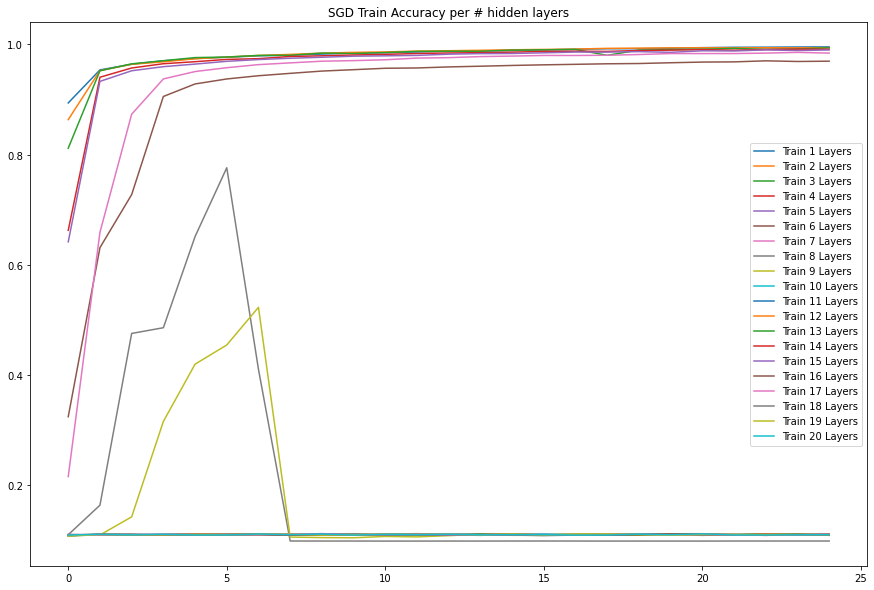

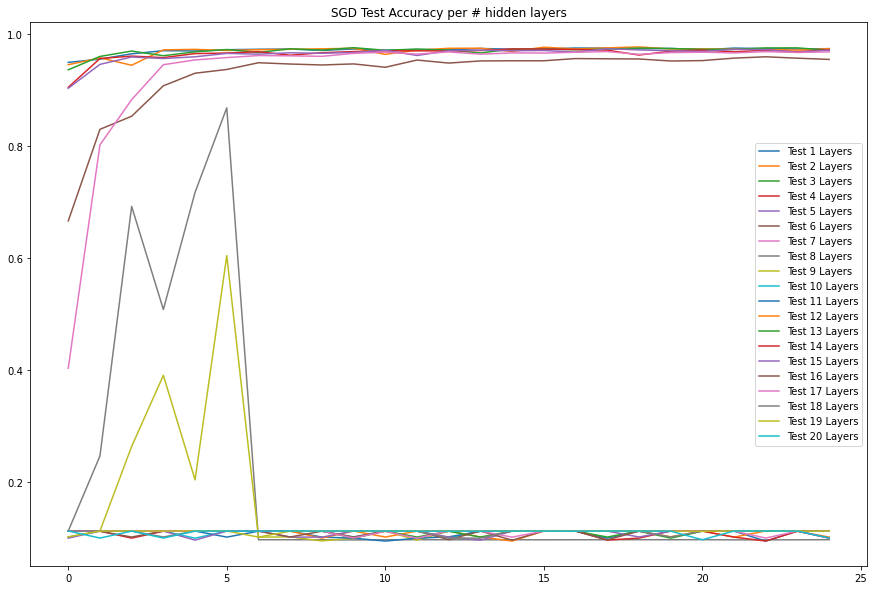

In [73]:
plt.figure(figsize=(15,10))
for d in range(len(sgd_train_depth_acc)):
    plt.plot(range(len(sgd_train_depth_acc[d])), sgd_train_depth_acc[d], label=f'Train {d+1} Layers')
plt.title('SGD Train Accuracy per # hidden layers')
plt.legend()

plt.figure(figsize=(15,10))
for d in range(len(sgd_test_depth_acc)):
    plt.plot(range(len(sgd_test_depth_acc[d])), sgd_test_depth_acc[d], label=f'Test {d+1} Layers')
plt.title('SGD Test Accuracy per # hidden layers')
plt.legend()


Train ADAM with learning rate 0.001 from 1 to 20 hidden layers with 50 hidden nodes in each layer.

In [30]:
adam_lr = 0.001
epochs = 25
depth = 20

adam_train_depth_acc, adam_test_depth_acc = train_to_depth(depth, torch.optim.Adam, adam_lr, trainloader, testloader, epochs)


Depth: 1
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch: 1, time: 6.215s, loss: 0.328, train accuracy: 0.869
Test accuracy: 0.923
Epoch: 2, time: 13.138s, loss: 0.183, train accuracy: 0.928
Test accuracy: 0.936
Epoch: 3, time: 20.014s, loss: 0.161, train accuracy: 0.942
Test accuracy: 0.946
Epoch: 4, time: 26.779s, loss: 0.147, train accuracy: 0.951
Test accuracy: 0.952
Epoch: 5, time: 33.534s, loss: 0.144, train accuracy: 0.957
Test accuracy: 0.957
Epoch: 6, time: 40.543s, loss: 0.136, train accuracy: 0.962
Test accuracy: 0.960
Epoch: 7, time: 49.254s, loss: 0.059, train accuracy: 0.966
Test accuracy: 0.960
Epoch: 8, time: 56.551s, loss: 0.073, train accuracy: 0.968
Test accuracy: 0.963
Epoch: 9, time: 63.254s, loss: 0.045, train accuracy: 0.971
Test accu

Test accuracy: 0.963
Epoch: 8, time: 68.428s, loss: 0.063, train accuracy: 0.975
Test accuracy: 0.963
Epoch: 9, time: 77.430s, loss: 0.073, train accuracy: 0.978
Test accuracy: 0.966
Epoch: 10, time: 86.849s, loss: 0.138, train accuracy: 0.980
Test accuracy: 0.967
Epoch: 11, time: 96.571s, loss: 0.067, train accuracy: 0.981
Test accuracy: 0.967
Epoch: 12, time: 106.501s, loss: 0.075, train accuracy: 0.983
Test accuracy: 0.968
Epoch: 13, time: 115.924s, loss: 0.059, train accuracy: 0.984
Test accuracy: 0.968
Epoch: 14, time: 124.929s, loss: 0.013, train accuracy: 0.986
Test accuracy: 0.964
Epoch: 15, time: 133.905s, loss: 0.030, train accuracy: 0.987
Test accuracy: 0.968
Epoch: 16, time: 142.749s, loss: 0.032, train accuracy: 0.987
Test accuracy: 0.971
Epoch: 17, time: 151.386s, loss: 0.048, train accuracy: 0.987
Test accuracy: 0.969
Epoch: 18, time: 160.387s, loss: 0.019, train accuracy: 0.989
Test accuracy: 0.967
Epoch: 19, time: 168.962s, loss: 0.048, train accuracy: 0.989
Test accur

Test accuracy: 0.967
Epoch: 12, time: 124.187s, loss: 0.031, train accuracy: 0.981
Test accuracy: 0.969
Epoch: 13, time: 135.290s, loss: 0.055, train accuracy: 0.982
Test accuracy: 0.966
Epoch: 14, time: 146.048s, loss: 0.030, train accuracy: 0.984
Test accuracy: 0.969
Epoch: 15, time: 156.588s, loss: 0.045, train accuracy: 0.984
Test accuracy: 0.965
Epoch: 16, time: 166.925s, loss: 0.050, train accuracy: 0.986
Test accuracy: 0.970
Epoch: 17, time: 177.049s, loss: 0.038, train accuracy: 0.986
Test accuracy: 0.968
Epoch: 18, time: 187.312s, loss: 0.026, train accuracy: 0.987
Test accuracy: 0.967
Epoch: 19, time: 197.128s, loss: 0.020, train accuracy: 0.988
Test accuracy: 0.966
Epoch: 20, time: 206.808s, loss: 0.005, train accuracy: 0.988
Test accuracy: 0.966
Epoch: 21, time: 216.561s, loss: 0.002, train accuracy: 0.989
Test accuracy: 0.969
Epoch: 22, time: 226.212s, loss: 0.042, train accuracy: 0.989
Test accuracy: 0.969
Epoch: 23, time: 235.856s, loss: 0.084, train accuracy: 0.990
Test

Test accuracy: 0.953
Epoch: 9, time: 103.178s, loss: 0.081, train accuracy: 0.967
Test accuracy: 0.960
Epoch: 10, time: 114.523s, loss: 0.147, train accuracy: 0.970
Test accuracy: 0.959
Epoch: 11, time: 126.570s, loss: 0.120, train accuracy: 0.973
Test accuracy: 0.962
Epoch: 12, time: 138.604s, loss: 0.016, train accuracy: 0.975
Test accuracy: 0.959
Epoch: 13, time: 150.650s, loss: 0.015, train accuracy: 0.976
Test accuracy: 0.964
Epoch: 14, time: 163.151s, loss: 0.089, train accuracy: 0.976
Test accuracy: 0.960
Epoch: 15, time: 176.748s, loss: 0.080, train accuracy: 0.977
Test accuracy: 0.962
Epoch: 16, time: 189.819s, loss: 0.058, train accuracy: 0.979
Test accuracy: 0.960
Epoch: 17, time: 202.087s, loss: 0.033, train accuracy: 0.980
Test accuracy: 0.963
Epoch: 18, time: 214.352s, loss: 0.096, train accuracy: 0.980
Test accuracy: 0.963
Epoch: 19, time: 226.140s, loss: 0.073, train accuracy: 0.981
Test accuracy: 0.965
Epoch: 20, time: 237.707s, loss: 0.033, train accuracy: 0.983
Test 

Epoch: 1, time: 12.480s, loss: 0.595, train accuracy: 0.468
Test accuracy: 0.797
Epoch: 2, time: 25.669s, loss: 0.566, train accuracy: 0.854
Test accuracy: 0.847
Epoch: 3, time: 38.690s, loss: 0.321, train accuracy: 0.909
Test accuracy: 0.915
Epoch: 4, time: 51.727s, loss: 0.379, train accuracy: 0.929
Test accuracy: 0.936
Epoch: 5, time: 64.717s, loss: 0.141, train accuracy: 0.941
Test accuracy: 0.940
Epoch: 6, time: 77.679s, loss: 0.084, train accuracy: 0.944
Test accuracy: 0.944
Epoch: 7, time: 90.771s, loss: 0.098, train accuracy: 0.949
Test accuracy: 0.943
Epoch: 8, time: 103.834s, loss: 0.097, train accuracy: 0.955
Test accuracy: 0.950
Epoch: 9, time: 116.872s, loss: 0.091, train accuracy: 0.959
Test accuracy: 0.952
Epoch: 10, time: 129.924s, loss: 0.099, train accuracy: 0.957
Test accuracy: 0.951
Epoch: 11, time: 142.865s, loss: 0.099, train accuracy: 0.964
Test accuracy: 0.957
Epoch: 12, time: 156.603s, loss: 0.114, train accuracy: 0.967
Test accuracy: 0.955
Epoch: 13, time: 170

Epoch: 24, time: 356.628s, loss: 0.097, train accuracy: 0.969
Test accuracy: 0.957
Epoch: 25, time: 371.019s, loss: 0.028, train accuracy: 0.973
Test accuracy: 0.961
Depth: 16
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): Linear(in_features=50, out_features=50, bias=True)
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): L

Epoch: 3, time: 46.917s, loss: 0.191, train accuracy: 0.894
Test accuracy: 0.923
Epoch: 4, time: 63.560s, loss: 0.254, train accuracy: 0.921
Test accuracy: 0.935
Epoch: 5, time: 80.287s, loss: 0.254, train accuracy: 0.940
Test accuracy: 0.942
Epoch: 6, time: 96.933s, loss: 0.142, train accuracy: 0.945
Test accuracy: 0.943
Epoch: 7, time: 112.952s, loss: 0.146, train accuracy: 0.951
Test accuracy: 0.946
Epoch: 8, time: 129.418s, loss: 0.222, train accuracy: 0.918
Test accuracy: 0.941
Epoch: 9, time: 145.646s, loss: 0.167, train accuracy: 0.956
Test accuracy: 0.954
Epoch: 10, time: 161.368s, loss: 0.107, train accuracy: 0.960
Test accuracy: 0.957
Epoch: 11, time: 177.241s, loss: 0.118, train accuracy: 0.964
Test accuracy: 0.959
Epoch: 12, time: 192.530s, loss: 0.163, train accuracy: 0.966
Test accuracy: 0.952
Epoch: 13, time: 208.269s, loss: 0.066, train accuracy: 0.966
Test accuracy: 0.961
Epoch: 14, time: 223.936s, loss: 0.177, train accuracy: 0.968
Test accuracy: 0.957
Epoch: 15, time

Test accuracy: 0.113
Epoch: 19, time: 331.631s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 20, time: 349.281s, loss: 2.305, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 21, time: 366.903s, loss: 2.294, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 22, time: 384.291s, loss: 2.296, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 23, time: 401.757s, loss: 2.307, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 24, time: 418.423s, loss: 2.311, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 25, time: 436.902s, loss: 2.303, train accuracy: 0.112
Test accuracy: 0.114


ADAM: Plot accuracies for each training run

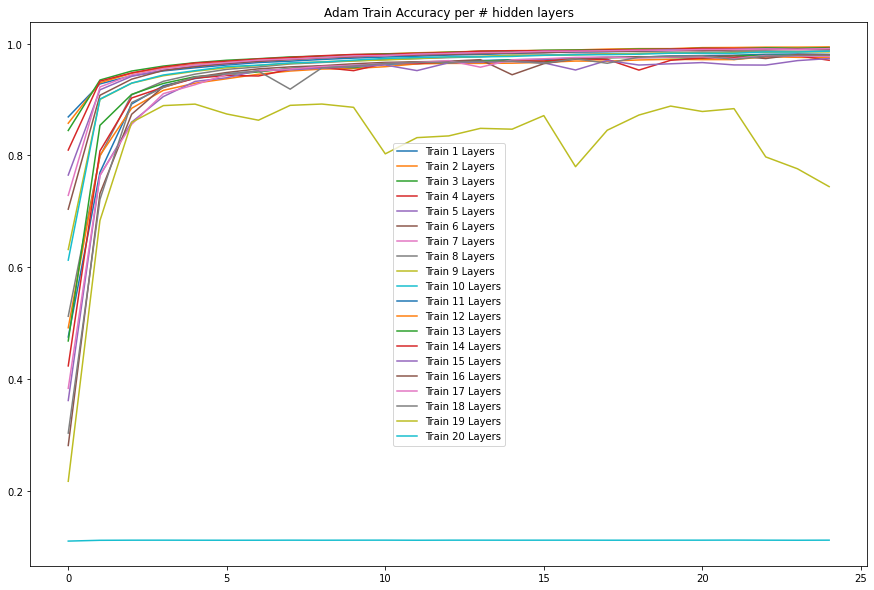

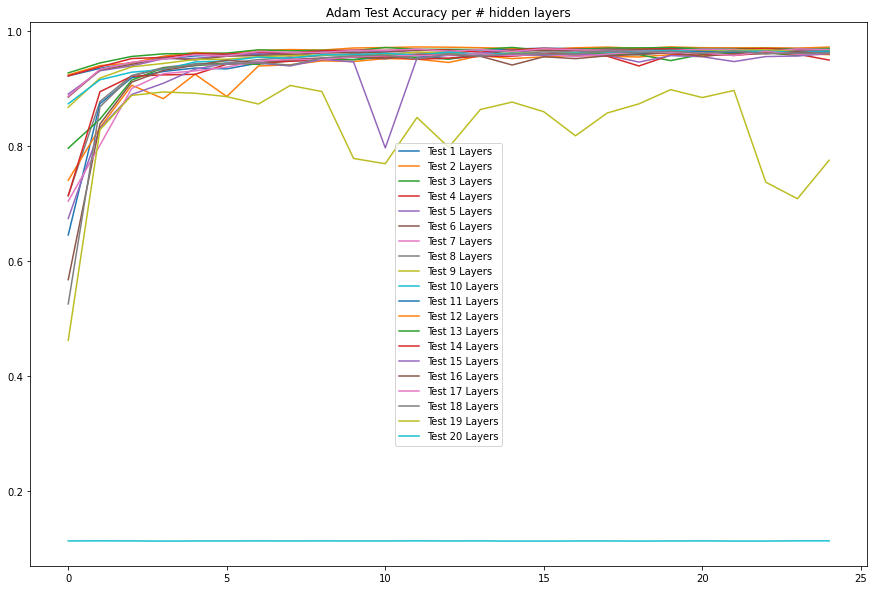

In [74]:
plt.figure(figsize=(15,10))
for d in range(len(adam_train_depth_acc)):
    plt.plot(range(len(adam_train_depth_acc[d])), adam_train_depth_acc[d], label=f'Train {d+1} Layers')
plt.title('Adam Train Accuracy per # hidden layers')
plt.legend()

plt.figure(figsize=(15,10))
for d in range(len(adam_test_depth_acc)):
    plt.plot(range(len(adam_test_depth_acc[d])), adam_test_depth_acc[d], label=f'Test {d+1} Layers')
plt.title('Adam Test Accuracy per # hidden layers')
plt.legend()

## Compare maximum accuracies between ADAM and SGD

Text(0.5, 1.0, 'Maximum Test accuracy after 25 epochs with varying numbers of hidden layers')

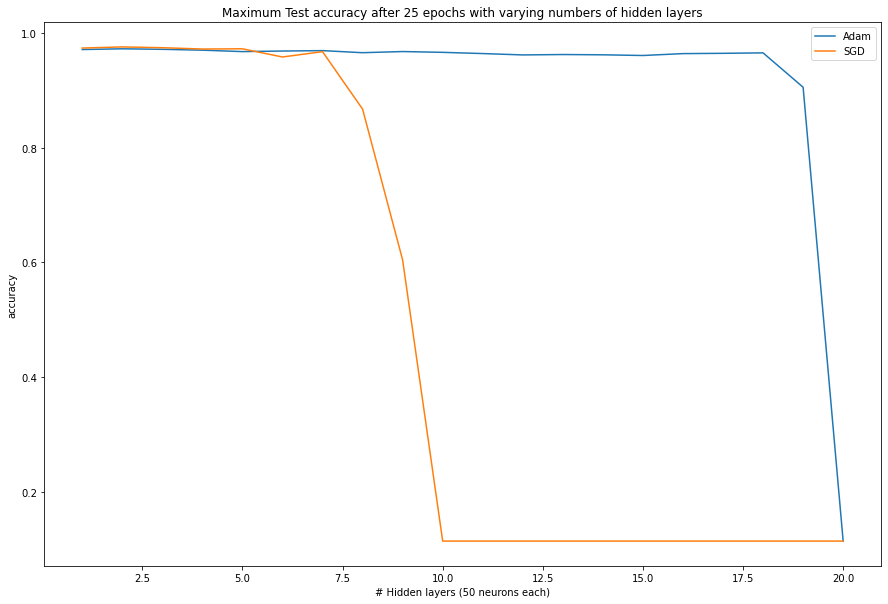

In [39]:
adam_acc = [max(adam_test) for adam_test in adam_test_depth_acc]
sgd_acc = [max(sgd_test) for sgd_test in sgd_test_depth_acc]

plt.figure(figsize=(15,10))
plt.plot(range(1,len(adam_acc)+1), adam_acc, label='Adam')
plt.plot(range(1,len(sgd_acc)+1), sgd_acc, label='SGD')
plt.xlabel('# Hidden layers (50 neurons each)')
plt.ylabel('accuracy')
plt.legend()
plt.title('Maximum Test accuracy after 25 epochs with varying numbers of hidden layers')


In [52]:
# Stats
adam_acc = [max(adam_test) for adam_test in adam_test_depth_acc]
sgd_acc = [max(sgd_test) for sgd_test in sgd_test_depth_acc]

print('ADAM:', adam_acc)
print('SGD:', sgd_acc)

ADAM: [0.9717, 0.973, 0.9721, 0.9706, 0.9681, 0.9691, 0.9698, 0.9662, 0.9682, 0.9668, 0.9647, 0.9623, 0.963, 0.9625, 0.9613, 0.9646, 0.9651, 0.9659, 0.9059, 0.1135]
SGD: [0.9743, 0.9763, 0.9749, 0.9726, 0.973, 0.9587, 0.968, 0.8677, 0.6043, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135]


## And stats for training accuracy

Text(0.5, 1.0, 'Maximum TRAIN accuracy after 25 epochs with varying numbers of hidden layers')

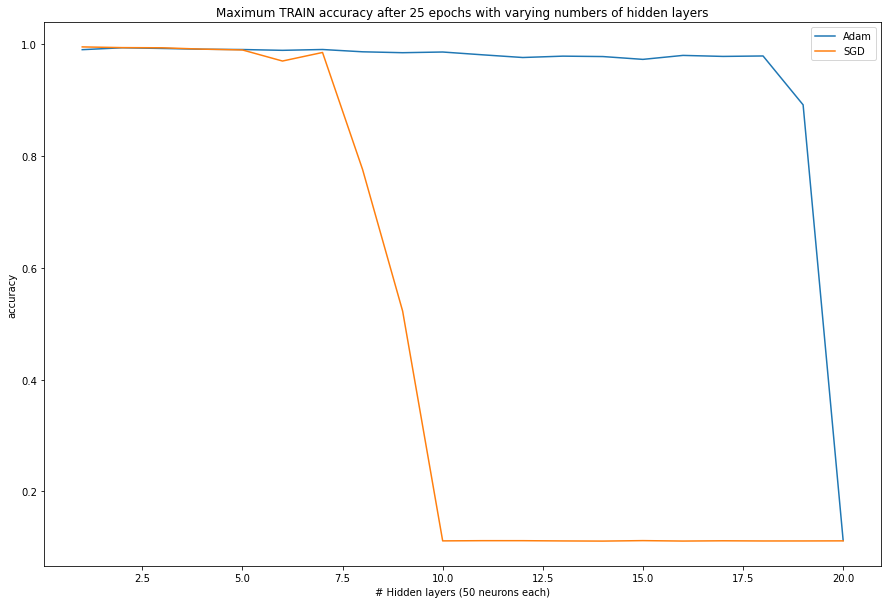

In [47]:
adam_acc = [max(adam_train) for adam_train in adam_train_depth_acc]
sgd_acc = [max(sgd_train) for sgd_train in sgd_train_depth_acc]

plt.figure(figsize=(15,10))
plt.plot(range(1,len(adam_acc)+1), adam_acc, label='Adam')
plt.plot(range(1,len(sgd_acc)+1), sgd_acc, label='SGD')
plt.xlabel('# Hidden layers (50 neurons each)')
plt.ylabel('accuracy')
plt.legend()
plt.title('Maximum TRAIN accuracy after 25 epochs with varying numbers of hidden layers')


## EXTRA: Question 2b - training SGD for learning rate 0.1

In [43]:
# lr = 0.1 instead
sgd01_lr = 0.1
epochs = 25
depth = 20

sgd01_train_depth_acc, sgd01_test_depth_acc = train_to_depth(depth, torch.optim.SGD, sgd01_lr, trainloader, testloader, epochs)


Depth: 1
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 1, time: 5.633s, loss: 0.392, train accuracy: 0.850
Test accuracy: 0.908
Epoch: 2, time: 11.888s, loss: 0.294, train accuracy: 0.913
Test accuracy: 0.925
Epoch: 3, time: 18.741s, loss: 0.379, train accuracy: 0.927
Test accuracy: 0.937
Epoch: 4, time: 25.466s, loss: 0.184, train accuracy: 0.938
Test accuracy: 0.938
Epoch: 5, time: 32.317s, loss: 0.121, train accuracy: 0.945
Test accuracy: 0.946
Epoch: 6, time: 38.988s, loss: 0.249, train accuracy: 0.950
Test accuracy: 0.950
Epoch: 7, time: 45.704s, loss: 0.131, train accuracy: 0.955
Test accuracy: 0.954
Epoch: 8, time: 52.528s, loss: 0.153, train accuracy: 0.959
Test accuracy: 0.958
Epoch: 9, time: 59.265s, loss: 0.108, train accuracy: 0.962
Test accuracy: 0.

Test accuracy: 0.965
Epoch: 9, time: 67.567s, loss: 0.011, train accuracy: 0.975
Test accuracy: 0.969
Epoch: 10, time: 75.062s, loss: 0.034, train accuracy: 0.978
Test accuracy: 0.965
Epoch: 11, time: 82.540s, loss: 0.061, train accuracy: 0.979
Test accuracy: 0.966
Epoch: 12, time: 89.905s, loss: 0.032, train accuracy: 0.980
Test accuracy: 0.968
Epoch: 13, time: 97.369s, loss: 0.094, train accuracy: 0.982
Test accuracy: 0.969
Epoch: 14, time: 105.485s, loss: 0.044, train accuracy: 0.984
Test accuracy: 0.967
Epoch: 15, time: 112.915s, loss: 0.074, train accuracy: 0.984
Test accuracy: 0.969
Epoch: 16, time: 121.163s, loss: 0.027, train accuracy: 0.985
Test accuracy: 0.968
Epoch: 17, time: 129.264s, loss: 0.064, train accuracy: 0.986
Test accuracy: 0.963
Epoch: 18, time: 136.904s, loss: 0.007, train accuracy: 0.988
Test accuracy: 0.970
Epoch: 19, time: 144.074s, loss: 0.029, train accuracy: 0.988
Test accuracy: 0.970
Epoch: 20, time: 151.315s, loss: 0.006, train accuracy: 0.988
Test accur

Test accuracy: 0.957
Epoch: 13, time: 156.759s, loss: 0.034, train accuracy: 0.971
Test accuracy: 0.961
Epoch: 14, time: 170.660s, loss: 0.047, train accuracy: 0.974
Test accuracy: 0.963
Epoch: 15, time: 184.055s, loss: 0.031, train accuracy: 0.976
Test accuracy: 0.963
Epoch: 16, time: 197.254s, loss: 0.111, train accuracy: 0.977
Test accuracy: 0.964
Epoch: 17, time: 210.484s, loss: 0.175, train accuracy: 0.978
Test accuracy: 0.958
Epoch: 18, time: 221.673s, loss: 0.041, train accuracy: 0.980
Test accuracy: 0.965
Epoch: 19, time: 232.140s, loss: 0.053, train accuracy: 0.982
Test accuracy: 0.964
Epoch: 20, time: 242.708s, loss: 0.040, train accuracy: 0.982
Test accuracy: 0.967
Epoch: 21, time: 252.982s, loss: 0.056, train accuracy: 0.983
Test accuracy: 0.965
Epoch: 22, time: 263.537s, loss: 0.038, train accuracy: 0.985
Test accuracy: 0.964
Epoch: 23, time: 274.528s, loss: 0.056, train accuracy: 0.985
Test accuracy: 0.965
Epoch: 24, time: 286.780s, loss: 0.005, train accuracy: 0.987
Test

Epoch: 10, time: 86.055s, loss: 2.306, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 11, time: 95.303s, loss: 2.297, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 12, time: 104.647s, loss: 2.306, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 13, time: 114.143s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 14, time: 123.854s, loss: 2.303, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 15, time: 133.550s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 16, time: 143.322s, loss: 2.303, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 17, time: 152.811s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 18, time: 162.125s, loss: 2.302, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 19, time: 171.512s, loss: 1.870, train accuracy: 0.161
Test accuracy: 0.220
Epoch: 20, time: 180.454s, loss: 1.435, train accuracy: 0.388
Test accuracy: 0.401
Epoch: 21, time: 189.644s, loss: 1.058, train accuracy: 0.568
Test accuracy: 0.611
Epoch:

Epoch: 1, time: 9.038s, loss: 2.308, train accuracy: 0.111
Test accuracy: 0.114
Epoch: 2, time: 18.870s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 3, time: 28.436s, loss: 2.296, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 4, time: 37.840s, loss: 2.296, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 5, time: 47.867s, loss: 2.307, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 6, time: 58.145s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 7, time: 68.490s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 8, time: 78.967s, loss: 2.296, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 9, time: 90.395s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 10, time: 101.513s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 11, time: 112.304s, loss: 2.297, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 12, time: 123.220s, loss: 2.302, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 13, time: 133.65

Test accuracy: 0.113
Epoch: 25, time: 293.304s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.113
Depth: 16
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): Linear(in_features=50, out_features=50, bias=True)
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): Linear(in_features=50, out_features=50, bias=True)
    (14): Li

Epoch: 4, time: 50.121s, loss: 2.291, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 5, time: 64.499s, loss: 2.299, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 6, time: 77.770s, loss: 2.302, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 7, time: 91.061s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 8, time: 103.576s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 9, time: 116.339s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 10, time: 129.351s, loss: 2.307, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 11, time: 142.466s, loss: 2.302, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 12, time: 154.268s, loss: 2.309, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 13, time: 167.067s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 14, time: 180.854s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 15, time: 192.783s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 16, tim

Test accuracy: 0.113
Epoch: 20, time: 264.470s, loss: 2.300, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 21, time: 276.187s, loss: 2.300, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 22, time: 288.090s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 23, time: 300.841s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 24, time: 314.386s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 25, time: 327.175s, loss: 2.296, train accuracy: 0.112
Test accuracy: 0.113


Text(0.5, 1.0, 'Maximum Test accuracy after 25 epochs with varying numbers of hidden layers')

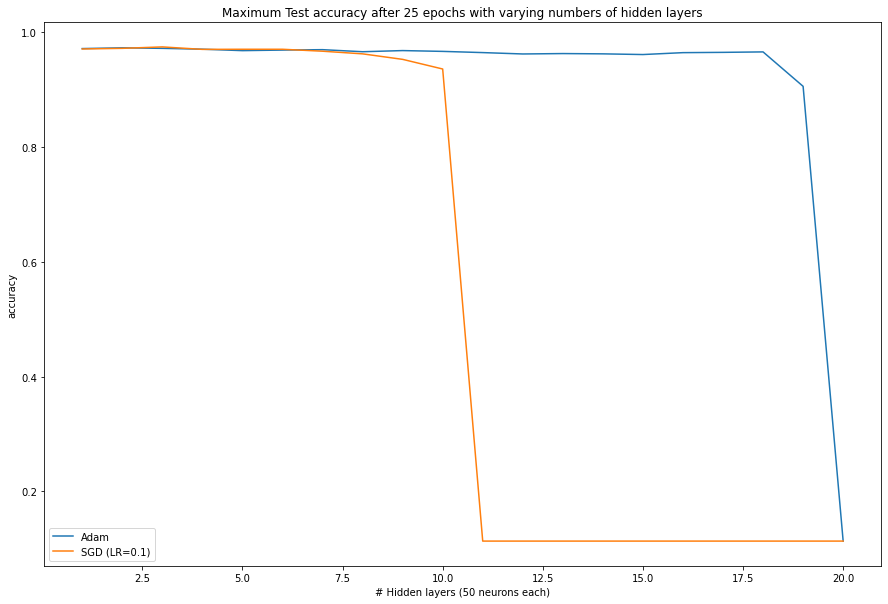

In [48]:
adam_acc = [max(adam_test) for adam_test in adam_test_depth_acc]
sgd01_acc = [max(sgd01_test) for sgd01_test in sgd01_test_depth_acc]

plt.figure(figsize=(15,10))
plt.plot(range(1,len(adam_acc)+1), adam_acc, label='Adam')
plt.plot(range(1,len(sgd01_acc)+1), sgd01_acc, label='SGD (LR=0.1)')
plt.xlabel('# Hidden layers (50 neurons each)')
plt.ylabel('accuracy')
plt.legend()
plt.title('Maximum Test accuracy after 25 epochs with varying numbers of hidden layers')


## EXTRA: Question 2b - training SGD for learning rate 0.01

In [49]:
# lr = 0.01 instead
sgd001_lr = 0.01
epochs = 25
depth = 20

sgd001_train_depth_acc, sgd001_test_depth_acc = train_to_depth(depth, torch.optim.SGD, sgd001_lr, trainloader, testloader, epochs)

Depth: 1
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 1, time: 5.697s, loss: 1.160, train accuracy: 0.635
Test accuracy: 0.795
Epoch: 2, time: 12.082s, loss: 0.684, train accuracy: 0.822
Test accuracy: 0.857
Epoch: 3, time: 18.404s, loss: 0.527, train accuracy: 0.859
Test accuracy: 0.880
Epoch: 4, time: 25.102s, loss: 0.372, train accuracy: 0.876
Test accuracy: 0.891
Epoch: 5, time: 31.810s, loss: 0.495, train accuracy: 0.886
Test accuracy: 0.897
Epoch: 6, time: 38.319s, loss: 0.359, train accuracy: 0.892
Test accuracy: 0.900
Epoch: 7, time: 44.610s, loss: 0.523, train accuracy: 0.897
Test accuracy: 0.902
Epoch: 8, time: 50.869s, loss: 0.305, train accuracy: 0.900
Test accuracy: 0.907
Epoch: 9, time: 57.184s, loss: 0.261, train accuracy: 0.903
Test accuracy: 0

Test accuracy: 0.855
Epoch: 9, time: 75.899s, loss: 0.455, train accuracy: 0.861
Test accuracy: 0.873
Epoch: 10, time: 83.335s, loss: 0.427, train accuracy: 0.876
Test accuracy: 0.884
Epoch: 11, time: 90.597s, loss: 0.589, train accuracy: 0.888
Test accuracy: 0.894
Epoch: 12, time: 98.138s, loss: 0.360, train accuracy: 0.895
Test accuracy: 0.904
Epoch: 13, time: 105.916s, loss: 0.391, train accuracy: 0.903
Test accuracy: 0.909
Epoch: 14, time: 114.114s, loss: 0.205, train accuracy: 0.909
Test accuracy: 0.913
Epoch: 15, time: 122.419s, loss: 0.355, train accuracy: 0.915
Test accuracy: 0.919
Epoch: 16, time: 130.344s, loss: 0.191, train accuracy: 0.920
Test accuracy: 0.923
Epoch: 17, time: 138.331s, loss: 0.191, train accuracy: 0.924
Test accuracy: 0.927
Epoch: 18, time: 146.136s, loss: 0.163, train accuracy: 0.928
Test accuracy: 0.930
Epoch: 19, time: 154.300s, loss: 0.191, train accuracy: 0.932
Test accuracy: 0.935
Epoch: 20, time: 162.696s, loss: 0.435, train accuracy: 0.935
Test accu

Test accuracy: 0.113
Epoch: 13, time: 106.283s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 14, time: 114.645s, loss: 2.292, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 15, time: 123.620s, loss: 2.294, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 16, time: 133.930s, loss: 2.303, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 17, time: 144.212s, loss: 2.302, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 18, time: 153.390s, loss: 2.310, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 19, time: 162.389s, loss: 2.289, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 20, time: 171.050s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 21, time: 179.409s, loss: 2.307, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 22, time: 187.548s, loss: 2.302, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 23, time: 195.604s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 24, time: 203.984s, loss: 2.304, train accuracy: 0.112
Test

Epoch: 10, time: 86.586s, loss: 2.299, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 11, time: 95.695s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 12, time: 105.064s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 13, time: 114.409s, loss: 2.300, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 14, time: 123.943s, loss: 2.310, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 15, time: 134.457s, loss: 2.303, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 16, time: 145.667s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 17, time: 158.001s, loss: 2.307, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 18, time: 169.270s, loss: 2.309, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 19, time: 179.649s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 20, time: 189.794s, loss: 2.308, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 21, time: 199.584s, loss: 2.295, train accuracy: 0.112
Test accuracy: 0.113
Epoch:

Epoch: 1, time: 9.764s, loss: 2.309, train accuracy: 0.099
Test accuracy: 0.101
Epoch: 2, time: 20.719s, loss: 2.298, train accuracy: 0.102
Test accuracy: 0.113
Epoch: 3, time: 31.436s, loss: 2.303, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 4, time: 42.660s, loss: 2.305, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 5, time: 53.853s, loss: 2.299, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 6, time: 66.250s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 7, time: 78.897s, loss: 2.306, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 8, time: 91.601s, loss: 2.299, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 9, time: 103.003s, loss: 2.307, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 10, time: 113.808s, loss: 2.305, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 11, time: 123.962s, loss: 2.304, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 12, time: 134.350s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 13, time: 144.2

Test accuracy: 0.113
Epoch: 25, time: 259.889s, loss: 2.299, train accuracy: 0.112
Test accuracy: 0.113
Depth: 16
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): Linear(in_features=50, out_features=50, bias=True)
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): Linear(in_features=50, out_features=50, bias=True)
    (14): Li

Epoch: 4, time: 42.433s, loss: 2.302, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 5, time: 53.525s, loss: 2.294, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 6, time: 64.363s, loss: 2.305, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 7, time: 75.172s, loss: 2.299, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 8, time: 86.046s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 9, time: 97.108s, loss: 2.300, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 10, time: 107.936s, loss: 2.296, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 11, time: 118.773s, loss: 2.301, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 12, time: 129.911s, loss: 2.306, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 13, time: 141.486s, loss: 2.293, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 14, time: 153.198s, loss: 2.294, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 15, time: 165.154s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 16, time:

Test accuracy: 0.113
Epoch: 20, time: 229.505s, loss: 2.294, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 21, time: 241.203s, loss: 2.309, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 22, time: 253.008s, loss: 2.292, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 23, time: 265.671s, loss: 2.298, train accuracy: 0.112
Test accuracy: 0.113
Epoch: 24, time: 279.084s, loss: 2.294, train accuracy: 0.112
Test accuracy: 0.114
Epoch: 25, time: 293.109s, loss: 2.308, train accuracy: 0.112
Test accuracy: 0.113


Text(0.5, 1.0, 'Maximum Test accuracy after 25 epochs with varying numbers of hidden layers')

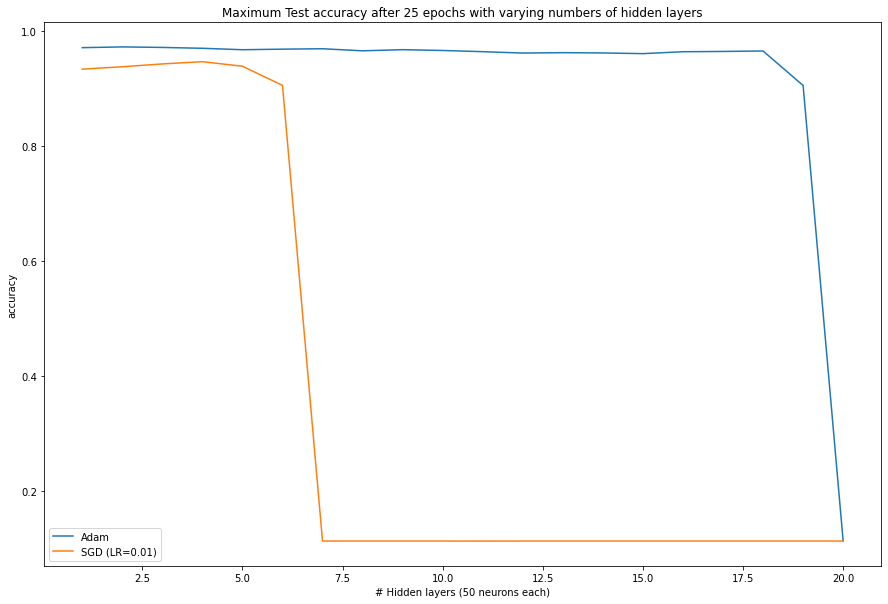

In [50]:
# accuracy at final epoch
adam_acc = [max(adam_test) for adam_test in adam_test_depth_acc]
sgd001_acc = [max(sgd001_test) for sgd001_test in sgd001_test_depth_acc]

plt.figure(figsize=(15,10))
plt.plot(range(1,len(adam_acc)+1), adam_acc, label='Adam')
plt.plot(range(1,len(sgd001_acc)+1), sgd001_acc, label='SGD (LR=0.01)')
plt.xlabel('# Hidden layers (50 neurons each)')
plt.ylabel('accuracy')
plt.legend()
plt.title('Maximum Test accuracy after 25 epochs with varying numbers of hidden layers')


In [53]:
# stats
adam_acc = [max(adam_test) for adam_test in adam_test_depth_acc]
sgd_acc = [max(sgd_test) for sgd_test in sgd001_test_depth_acc]

print('ADAM:', adam_acc)
print('SGD:', sgd_acc)

ADAM: [0.9717, 0.973, 0.9721, 0.9706, 0.9681, 0.9691, 0.9698, 0.9662, 0.9682, 0.9668, 0.9647, 0.9623, 0.963, 0.9625, 0.9613, 0.9646, 0.9651, 0.9659, 0.9059, 0.1135]
SGD: [0.9343, 0.9385, 0.9434, 0.9473, 0.9394, 0.9061, 0.1135, 0.1135, 0.1135, 0.1135, 0.1134, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135]
